---
---

### What influences attraction queue times?

Theme parks want to attract business from guests all around the world. Large and well-known parks like Disneyland, Universal Studios, and Six Flags can see millions of visitors annually. According to [Forbes](https://www.forbes.com/sites/suzannerowankelleher/2024/08/16/how-disney-dominated-the-theme-park-industry-in-2023/), in 2023 the top 25 parks collectively drew in 244.6 million guests.

A major draw to these parks are the attractions guests can ride and experience. As a guest, a low queue time is desired so one can experience the ride as soon as possible, and experience more throughout the limited time spent at the park. 

Theme park owners would therefore benefit from understanding what drives attraction queue times up, and guests would be better able to plan their stays if they can anticipate certain days or attractions that will have long queue times.

---
---

#### The objective:

**Explore theme park data to determine which features are most significant in the prediction of attraction queue times. The data may need to be cleaned and transformed in order to be used in linear models for analysis. We will then evaluate the models performance and assess whether feature engineering improvements should be made. For the stakeholders, we may consider what recommendations are available for the upcoming quarters.**

In [933]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings('ignore')

#### Inspect the data:

1. Use methods such as `head()`, `tail()`, and `info()` to inspect the data
- Note the data types
- Note any null values

2. Determine if any qualitative data should be converted into quantitative (or any other strings to ints)
- If there is qualitative data, consider using `.unique()` to see what the range of values are for this feature

3. Note how many records are available

4. Scan for any outliers or features that may be dropped

In [934]:
attendance = pd.read_csv('data/attendance.csv')
wait = pd.read_csv('data/waiting_times.csv')
weather = pd.read_csv('data/weather_data.csv')
link = pd.read_csv('data/link_attraction_park.csv')

In [935]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2367 entries, 0 to 2366
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   USAGE_DATE     2367 non-null   object
 1   FACILITY_NAME  2367 non-null   object
 2   attendance     2367 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 55.6+ KB


In [936]:
wait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3509324 entries, 0 to 3509323
Data columns (total 14 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   WORK_DATE                 object 
 1   DEB_TIME                  object 
 2   DEB_TIME_HOUR             int64  
 3   FIN_TIME                  object 
 4   ENTITY_DESCRIPTION_SHORT  object 
 5   WAIT_TIME_MAX             int64  
 6   NB_UNITS                  float64
 7   GUEST_CARRIED             float64
 8   CAPACITY                  float64
 9   ADJUST_CAPACITY           float64
 10  OPEN_TIME                 int64  
 11  UP_TIME                   int64  
 12  DOWNTIME                  int64  
 13  NB_MAX_UNIT               float64
dtypes: float64(5), int64(5), object(4)
memory usage: 374.8+ MB


In [937]:
link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ATTRACTION;PARK  39 non-null     object
dtypes: object(1)
memory usage: 444.0+ bytes


In [938]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207264 entries, 0 to 207263
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   207264 non-null  int64  
 1   dt_iso               207264 non-null  object 
 2   timezone             207264 non-null  int64  
 3   city_name            207264 non-null  object 
 4   lat                  207264 non-null  float64
 5   lon                  207264 non-null  float64
 6   temp                 207264 non-null  float64
 7   visibility           0 non-null       float64
 8   dew_point            207264 non-null  float64
 9   feels_like           207264 non-null  float64
 10  temp_min             207264 non-null  float64
 11  temp_max             207264 non-null  float64
 12  pressure             207264 non-null  int64  
 13  sea_level            0 non-null       float64
 14  grnd_level           0 non-null       float64
 15  humidity         

In [939]:
attendance.head()

,USAGE_DATE,FACILITY_NAME,attendance
0,2018-06-01,PortAventura World,46804
1,2018-06-01,Tivoli Gardens,20420
2,2018-06-02,PortAventura World,57940
3,2018-06-02,Tivoli Gardens,29110
4,2018-06-03,PortAventura World,44365


In [940]:
wait.head()

,WORK_DATE,DEB_TIME,DEB_TIME_HOUR,FIN_TIME,ENTITY_DESCRIPTION_SHORT,WAIT_TIME_MAX,NB_UNITS,GUEST_CARRIED,CAPACITY,ADJUST_CAPACITY,OPEN_TIME,UP_TIME,DOWNTIME,NB_MAX_UNIT
0,2018-01-01,2018-01-01 21:00:00.000,21,2018-01-01 21:15:00.000,Roller Coaster,0,2.0,0.0,0.000,0.00,0,0,0,2.0
1,2018-01-01,2018-01-01 19:30:00.000,19,2018-01-01 19:45:00.000,Bumper Cars,5,18.0,148.0,254.749,254.75,15,15,0,18.0
2,2018-01-01,2018-01-01 22:30:00.000,22,2018-01-01 22:45:00.000,Rapids Ride,0,1.0,0.0,0.000,0.00,0,0,0,2.0
3,2018-01-01,2018-01-01 12:45:00.000,12,2018-01-01 13:00:00.000,Crazy Dance,5,1.0,46.0,250.001,250.00,15,15,0,1.0
4,2018-01-01,2018-01-01 17:00:00.000,17,2018-01-01 17:15:00.000,Skyway,5,15.0,92.0,211.500,198.25,15,15,0,16.0


In [941]:
weather.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,915148800,1999-01-01 00:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,8.33,NaN,3.39,5.28,...,NaN,NaN,NaN,NaN,NaN,8,800,Clear,sky is clear,01n
1,915152400,1999-01-01 01:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,8.08,NaN,3.54,5.18,...,NaN,NaN,NaN,NaN,NaN,6,800,Clear,sky is clear,01n
2,915156000,1999-01-01 02:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,8.08,NaN,4.11,5.38,...,NaN,NaN,NaN,NaN,NaN,14,801,Clouds,few clouds,02n
3,915159600,1999-01-01 03:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,7.31,NaN,3.73,4.42,...,NaN,NaN,NaN,NaN,NaN,39,802,Clouds,scattered clouds,03n
4,915163200,1999-01-01 04:00:00 +0000 UTC,3600,Custom location,48.873492,2.295104,6.91,NaN,3.53,4.00,...,NaN,NaN,NaN,NaN,NaN,52,803,Clouds,broken clouds,04n


In [942]:
link.head()

,ATTRACTION;PARK
0,Aeroplane Ride;Tivoli Gardens
1,Bumper Cars;PortAventura World
2,Bungee Jump;PortAventura World
3,Circus Train;PortAventura World
4,Crazy Bus;Tivoli Gardens


In [943]:
'''
I'd rather have the link dataframe have ATTRACTION and PARK be separate columns. Let's split that original column and 
set two columns from the data:
'''

link[['ATTRACTION', 'PARK']] = link['ATTRACTION;PARK'].str.split(';', expand=True)
link.head()

,ATTRACTION;PARK,ATTRACTION,PARK
0,Aeroplane Ride;Tivoli Gardens,Aeroplane Ride,Tivoli Gardens
1,Bumper Cars;PortAventura World,Bumper Cars,PortAventura World
2,Bungee Jump;PortAventura World,Bungee Jump,PortAventura World
3,Circus Train;PortAventura World,Circus Train,PortAventura World
4,Crazy Bus;Tivoli Gardens,Crazy Bus,Tivoli Gardens


In [944]:
'''
Create lists of columns to drop--
There are several columns here amongst all of the data. Some of these columns contain many null values, are not as relevant to 
the models I wish to create, and we ideally would want to merge the data into one final, cleaned dataframe to work with. I'll 
start by creating lists of the column names to drop.
'''

wait_drops = ['DEB_TIME', 'DEB_TIME_HOUR', 'FIN_TIME', 'NB_UNITS', 'ADJUST_CAPACITY', 'OPEN_TIME', 'UP_TIME', 'NB_MAX_UNIT' ]
weather_drops =['dt_iso', 'timezone', 'lat', 'lon', 'temp_min', 'temp_max', 'wind_gust', 'city_name', 'visibility', 'dew_point', 'feels_like', 
                'pressure', 'sea_level', 'grnd_level', 'wind_deg', 'rain_1h', 'rain_3h', 
                'snow_1h', 'snow_3h','clouds_all', 'weather_id','weather_description', 'weather_icon']

wait = wait.drop(columns=wait_drops)
weather = weather.drop(columns=weather_drops)
link = link.drop(columns=['ATTRACTION;PARK'])

In [945]:
'''
For the wait time data, we drop some excess data and filter for where WAIT_TIME_MAX > 0 so we only work with actual queues 
and no 'walk-ons'
'''
wait = wait[wait['WAIT_TIME_MAX'] > 0]

In [946]:
'''
Now that we've dropped a few columns, and filtered for attractions with a positive wait time, let's standardize the names of 
similar columns that hold data like dates or the park names. Since the dates data is in different formats, I'll also use 
pd.to_datetime() to set the date values
'''

attendance = attendance.rename(columns={'USAGE_DATE': 'date', 'FACILITY_NAME': 'park'})
wait = wait.rename(columns={'WORK_DATE': 'date', 'ENTITY_DESCRIPTION_SHORT': 'attraction', 'WAIT_TIME_MAX': 'wait'})
link = link.rename(columns={'ATTRACTION': 'attraction', 'PARK': 'park'})

weather['dt'] = pd.to_datetime(weather['dt'], unit='s')
weather['dt'] = weather['dt'].dt.strftime('%Y-%m-%d')
weather = weather.rename(columns={'dt': 'date'})

In [947]:
attendance.head()

,date,park,attendance
0,2018-06-01,PortAventura World,46804
1,2018-06-01,Tivoli Gardens,20420
2,2018-06-02,PortAventura World,57940
3,2018-06-02,Tivoli Gardens,29110
4,2018-06-03,PortAventura World,44365


In [948]:
wait.head()

,date,attraction,wait,GUEST_CARRIED,CAPACITY,DOWNTIME
1,2018-01-01,Bumper Cars,5,148.0,254.749,0
3,2018-01-01,Crazy Dance,5,46.0,250.001,0
4,2018-01-01,Skyway,5,92.0,211.500,0
5,2018-01-01,Free Fall,50,0.0,0.000,0
6,2018-01-01,Monorail,70,145.0,223.751,0


In [949]:
link.head()

,attraction,park
0,Aeroplane Ride,Tivoli Gardens
1,Bumper Cars,PortAventura World
2,Bungee Jump,PortAventura World
3,Circus Train,PortAventura World
4,Crazy Bus,Tivoli Gardens


In [950]:
weather.head()

,date,temp,humidity,wind_speed,weather_main
0,1999-01-01,8.33,71,5.57,Clear
1,1999-01-01,8.08,73,5.02,Clear
2,1999-01-01,8.08,76,4.56,Clouds
3,1999-01-01,7.31,78,4.56,Clouds
4,1999-01-01,6.91,79,4.40,Clouds


In [951]:
'''
We'll eventually want to merge everything into one cleaned dataframe. We will call one dataframe `paw` for PortAventura World. 
A second dataframe will be used for Tivoli Gardens called `tiv`.
'''

wait_link = pd.merge(wait, link, on='attraction', how='left')
attendance_weather = pd.merge(attendance, weather, on='date', how='left')

In [952]:
wait_link.head()

,date,attraction,wait,GUEST_CARRIED,CAPACITY,DOWNTIME,park
0,2018-01-01,Bumper Cars,5,148.0,254.749,0,PortAventura World
1,2018-01-01,Crazy Dance,5,46.0,250.001,0,PortAventura World
2,2018-01-01,Skyway,5,92.0,211.500,0,Tivoli Gardens
3,2018-01-01,Free Fall,50,0.0,0.000,0,PortAventura World
4,2018-01-01,Monorail,70,145.0,223.751,0,Tivoli Gardens


In [953]:
attendance_weather.head()

,date,park,attendance,temp,humidity,wind_speed,weather_main
0,2018-06-01,PortAventura World,46804,17.08,94,2.31,Clouds
1,2018-06-01,PortAventura World,46804,16.70,94,2.66,Clouds
2,2018-06-01,PortAventura World,46804,16.26,94,2.73,Clouds
3,2018-06-01,PortAventura World,46804,16.45,95,2.28,Clouds
4,2018-06-01,PortAventura World,46804,15.79,96,1.96,Clouds


In [954]:
both_parks = pd.merge(wait_link, attendance_weather, on=['date', 'park'], how='left')
both_parks.columns = both_parks.columns.str.lower()
both_parks = both_parks.dropna()

In [955]:
'''
In a real-world scenario I may be reviewing years of theme park data but it is also likely I would be asked to review 
a previous quarter or even a previous year's performance. For the purpose of this investigation I will choose a subset of the data 
from 2019 to analyze. 

I choose the year 2019 because we have access to the full year of data for 2019 and for the years following much of the world
had been practicing social distancing due to Covid which may affect theme park attendance.
'''

# First quarter of the year
start_date = '2019-01-01'
end_date = '2019-03-31'

both_parks = both_parks[(both_parks['date'] >= start_date) & (both_parks['date'] <= end_date)]

In [956]:
# I will now separate the two parks to focus analysis on PortAventura World which will be referred to as `paw`
paw = both_parks[both_parks['park'] == 'PortAventura World']
tiv = both_parks[both_parks['park'] == 'Tivoli Gardens']

paw = paw.drop(columns=['park'])
tiv = tiv.drop(columns=['park'])

In [957]:
'''
There is still a lot of data we are handling, and it is taking a long time to process all attractions. In order to speed
up the model generation and processing we will focus on one type of attraction, the `Flying Coaster` as this will have 
generally consistent capacity and ride duration. We could repeat the same processes for each attraction depending on the 
needs of the stakeholder or to compare how attraction wait times are impacted across a variety of different attraction types.
'''
paw = paw[paw['attraction'] == 'Flying Coaster']
paw = paw.drop(columns=['attraction'])

paw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85320 entries, 7589202 to 9989081
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           85320 non-null  object 
 1   wait           85320 non-null  int64  
 2   guest_carried  85320 non-null  float64
 3   capacity       85320 non-null  float64
 4   downtime       85320 non-null  int64  
 5   attendance     85320 non-null  float64
 6   temp           85320 non-null  float64
 7   humidity       85320 non-null  float64
 8   wind_speed     85320 non-null  float64
 9   weather_main   85320 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 7.2+ MB


In [958]:
'''
Now I want to explore the unique values for different fields. Since there are many columns we can use a 
function to print out the unique values for each column efficiently. We will consider converting some dtypes to ints 
or use OneHotEncoder / OrdinalEncoder later on in the models.
'''

def returnUniques(field, df):
    print(f'{field.upper()} unique values: {df[field].unique()}')

returnUniques("wait", paw)
returnUniques("downtime", paw)
returnUniques("guest_carried", paw)
returnUniques("capacity", paw)
returnUniques("temp", paw)
returnUniques("weather_main", paw)

WAIT unique values: [40 15  5 25 50 35 60 30 20 10 55 45 80 70 75 65]
DOWNTIME unique values: [ 0 11 15  1  8  6  5  2  3  9 14 13 12 10  7  4]
GUEST_CARRIED unique values: [485.      52.     108.     510.     567.     451.     568.     238.
 262.       0.     349.     543.     474.     399.     504.     385.
 435.     508.     447.     500.     464.     487.     489.     440.
 523.     455.     503.     411.     456.     495.     443.     493.
 430.     553.     424.     492.     246.     530.     458.     461.
 476.     186.     314.     446.     525.     505.     537.     617.
 524.     563.     408.     199.     463.     324.     452.     520.
 423.     465.     478.     462.     420.     425.     173.     394.
 550.     472.     556.     433.     536.     468.      31.     547.
 475.     566.     552.     573.     619.     538.     491.     387.
 384.     533.     340.     554.     296.     482.     473.     597.
 521.     382.     459.     557.     486.     293.     466.     625.

---
#### Briefly visualize the data and how it is spread

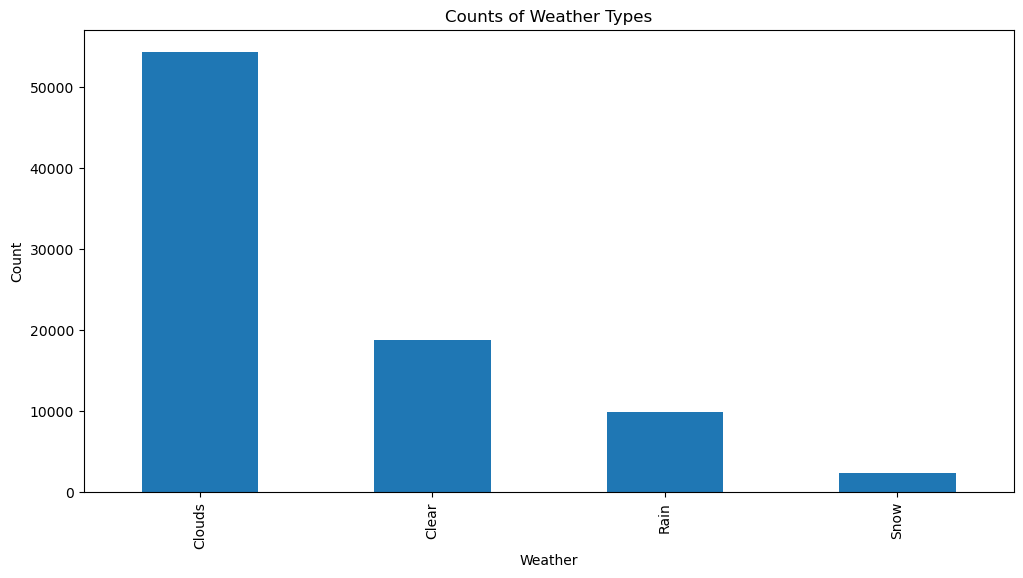

In [959]:
plt.figure(figsize=(12, 6))
paw['weather_main'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Weather')
plt.ylabel('Count')
plt.title('Counts of Weather Types')
plt.show()

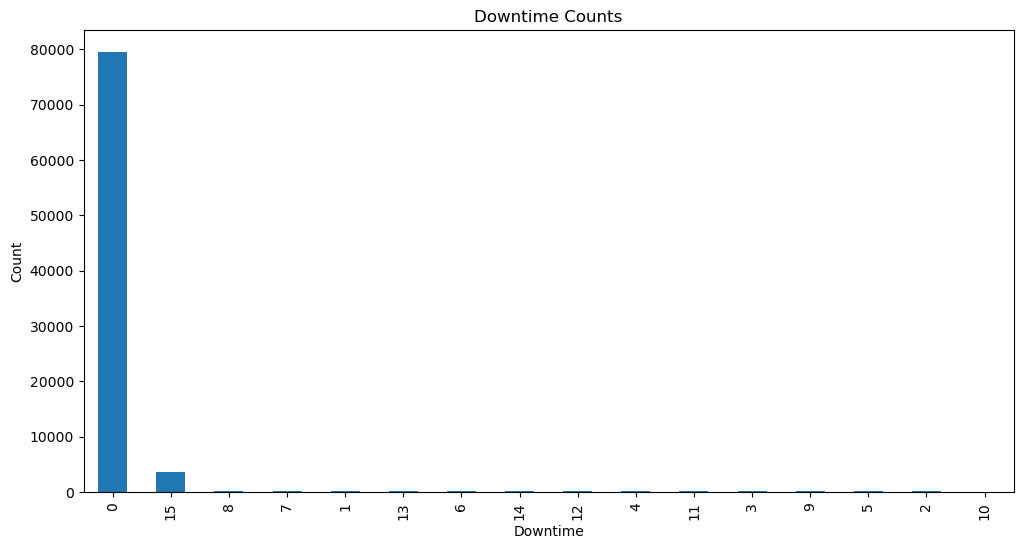

In [960]:
plt.figure(figsize=(12, 6))
paw['downtime'].value_counts().plot(kind='bar')
plt.xticks(rotation=90)
plt.xlabel('Downtime')
plt.ylabel('Count')
plt.title('Downtime Counts')
plt.show()

---
---

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling. 
I decide to drop one more column, as explained below, and continue on to create train and test splits to be used in the models.

---
---

In [961]:
# Using the returnUniques we could see there were a few different values for `downtime` recorded. However, the counts 
# of downtime other than 0 is minimal. I'm going to ignore and drop this downtime column and focus on the other 
# features for this analysis. We would know that an attraction is slow or otherwise unavailable during some 
# planned or unexpected downtime anyway.

paw = paw.drop(columns=['downtime'])
tiv = tiv.drop(columns=['downtime'])

paw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85320 entries, 7589202 to 9989081
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           85320 non-null  object 
 1   wait           85320 non-null  int64  
 2   guest_carried  85320 non-null  float64
 3   capacity       85320 non-null  float64
 4   attendance     85320 non-null  float64
 5   temp           85320 non-null  float64
 6   humidity       85320 non-null  float64
 7   wind_speed     85320 non-null  float64
 8   weather_main   85320 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 6.5+ MB


#### Inspection summary:

We collected data for 85320 entries. Most of the fields are numbers and therefore we won't need to convert many to ints or utilize OneHotEncoder/OrdinalEncoder in the model creation. The only field to use OrdinalEncoder is `weather_main`.

I reduced the total entries drastically to improve runtime and focus specifically on a particular park and particular attraction
type. Now we will begin setting our train and test sets and a column transformer to generate our models.

In [962]:
X = paw.drop('wait', axis = 1)
y = paw['wait']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [963]:
'''
Let's see what numerical feature is most correlated to wait times
'''

paw_ints = paw.select_dtypes(include=np.number)
corrs = paw_ints.corr()[['wait']].nlargest(columns = 'wait', n=len(paw_ints))
corrs

,wait
wait,1.000000
attendance,0.658456
guest_carried,0.286995
temp,0.273832
capacity,0.121032
wind_speed,-0.017126
humidity,-0.156921


In [964]:
'''
Now let's set up the column transformer. I'm only using the OrdinalEncoder now, and determined the order based on how the weather
state would affect overall temperature, visibility, and safety of ride operations.
'''

weather_categories = [['Snow', 'Rain', 'Clouds', 'Clear' ]]

column_transformer = make_column_transformer((PolynomialFeatures(), make_column_selector(dtype_include=np.number)),
                                           (OrdinalEncoder(categories = weather_categories), ['weather_main']))

---
---

### Modeling

Now that I have my data prepared, a train and test set available, as well as a column transformer for my pipelines, I begin to start building various models. 

---
---

In [965]:
# Recap of all features included in the final data we prepared. I'll note the one feature we are using an OrdinalEncoder with:

all_features = list(X_train.columns)
print('All features:')
print(all_features)

print('Ordinals:')
print(['weather_main'])

All features:
['date', 'guest_carried', 'capacity', 'attendance', 'temp', 'humidity', 'wind_speed', 'weather_main']
Ordinals:
['weather_main']


#### Sequential Feature Selector

In [966]:
sfs_pipe = Pipeline([
    ('transformer', column_transformer),
    ('selector', SequentialFeatureSelector(LinearRegression())),
    ('model', LinearRegression())
])

params = {'selector__n_features_to_select': [2, 3, 4, 5]}
sfs_grid = GridSearchCV(sfs_pipe, param_grid=params)
sfs_grid.fit(X_train, y_train)

sfs_train_preds = sfs_grid.predict(X_train)
sfs_test_preds = sfs_grid.predict(X_test)

sfs_train_mse = mean_squared_error(y_train, sfs_train_preds)
sfs_test_mse = mean_squared_error(y_test, sfs_test_preds)

print(f'SFS - Train MSE: {sfs_train_mse}')
print(f'SFS - Test MSE: {sfs_test_mse}')

SFS - Train MSE: 145.29669481812576
SFS - Test MSE: 143.1093808560061


#### Ridge
Creating Ridge models with alphas of np.logspace(0, 10, 50)

In [967]:
ridge_params = {'ridge__alpha': np.logspace(0, 10, 50)}
ridge_pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

ridge_grid = GridSearchCV(ridge_pipe, param_grid=ridge_params)
ridge_grid.fit(X_train, y_train)

ridge_train_preds = ridge_grid.predict(X_train)
ridge_test_preds = ridge_grid.predict(X_test)

ridge_train_mse = mean_squared_error(y_train, ridge_train_preds)
ridge_test_mse = mean_squared_error(y_test, ridge_test_preds)

print(f'Ridge Feature 1 - Train MSE: {ridge_train_mse}')
print(f'Ridge Feature 1 - Test MSE: {ridge_test_mse}')

Ridge Feature 1 - Train MSE: 141.5425694276682
Ridge Feature 1 - Test MSE: 140.01795194265148


#### LASSO

In [968]:
lasso_pipe = Pipeline([
    ('transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state = 42))
])

lasso_pipe.fit(X_train, y_train)
lasso_coefs = lasso_pipe.named_steps['lasso'].coef_

lasso_train_mse = mean_squared_error(y_train, lasso_pipe.predict(X_train))
lasso_test_mse = mean_squared_error(y_test, lasso_pipe.predict(X_test))

print(f'LASSO Feature 1 - Train MSE: {lasso_train_mse}')
print(f'LASSO Feature 1 - Test MSE: {lasso_test_mse}')

LASSO Feature 1 - Train MSE: 150.1647053309674
LASSO Feature 1 - Test MSE: 147.55477846440508


---
---

### Evaluation

Now that I've generated three different models (SFS, Ridge, and LASSO) we can determine the quality of the models and begin analyzing our 
findings. Let's see if there are any results that are notable and can help direct the theme park owners on how to prepare for the 
upcoming quarter.

---
---

#### Sequential Feature Selector

In [969]:
sfs_best_estimator = sfs_grid.best_estimator_
sfs_best_selector = sfs_best_estimator.named_steps['selector']
sfs_best_model = sfs_grid.best_estimator_.named_steps['model']

sfs_column_transformer_step = sfs_best_estimator.named_steps['transformer']
sfs_X_train_transformed = sfs_column_transformer_step.transform(X_train)

sfs_feature_names = sfs_column_transformer_step.get_feature_names_out()
sfs_X_train_transformed_df = pd.DataFrame(sfs_X_train_transformed, columns=sfs_feature_names)

sfs_selected_feature_names = sfs_X_train_transformed_df.columns[sfs_best_selector.get_support()]
print(f"Selected features: {sfs_selected_feature_names}")

sfs_coefs = sfs_best_model.coef_
print(f'Coefficients: {pd.DataFrame([sfs_coefs], columns=sfs_selected_feature_names, index=["model"])}')

Selected features: Index(['polynomialfeatures__guest_carried^2',
       'polynomialfeatures__guest_carried attendance',
       'polynomialfeatures__capacity attendance',
       'polynomialfeatures__attendance^2',
       'polynomialfeatures__attendance wind_speed'],
      dtype='object')
Coefficients:        polynomialfeatures__guest_carried^2  \
model                            -0.000044   

       polynomialfeatures__guest_carried attendance  \
model                                      0.000001   

       polynomialfeatures__capacity attendance  \
model                             5.400133e-07   

       polynomialfeatures__attendance^2  \
model                     -2.389284e-09   

       polynomialfeatures__attendance wind_speed  
model                                   0.000013  


#### LASSO

In [975]:
lasso_feature_names = lasso_pipe.named_steps['transformer'].get_feature_names_out()
lasso_df = pd.DataFrame({'feature': lasso_feature_names, 'coef': lasso_coefs})

print('LASSO Model Coefficients')
lasso_df.loc[lasso_df['coef'] != 0].sort_values(by='coef', ascending=False)

LASSO Model Coefficients


,feature,coef
14,polynomialfeatures__capacity attendance,7.042398
9,polynomialfeatures__guest_carried attendance,3.276521
19,polynomialfeatures__attendance temp,0.554614
21,polynomialfeatures__attendance wind_speed,0.488362
20,polynomialfeatures__attendance humidity,0.124104


In [971]:
'''
Let's visualize and compare the MSEs in a new table:
'''

feature_MSEs = {
    'SFS Train': sfs_train_mse,
    'SFS Test': sfs_test_mse,
    'Ridge Train': ridge_train_mse,
    'Ridge Test': ridge_test_mse,
    'LASSO Train' : lasso_train_mse,
    'LASSO Test' : lasso_test_mse
    
}

feature_mse_df = pd.DataFrame(list(feature_MSEs.items()), columns=['Model', 'MSE'])
feature_mse_df

,Model,MSE
0,SFS Train,145.296695
1,SFS Test,143.109381
2,Ridge Train,141.542569
3,Ridge Test,140.017952
4,LASSO Train,150.164705
5,LASSO Test,147.554778


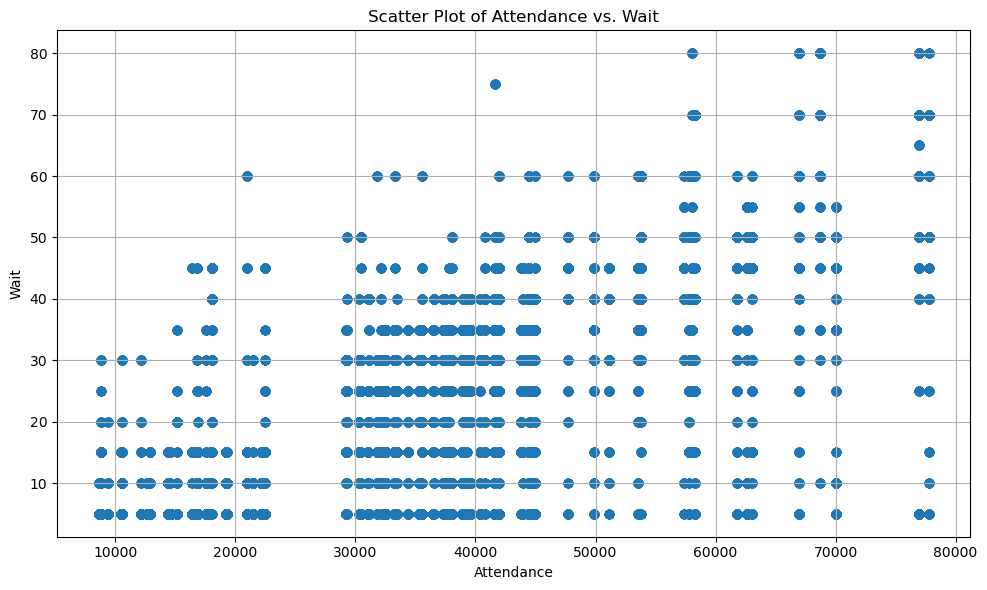

In [973]:
# We saw earlier that attendance was highly correlated to wait times (`corrs` variable earlier). Our models show that it is
# a significant feature, as expected. Generally a high park attendance will result in longer queue times since there are 
# simply more people in the park. Let's plot the attendance against the wait times below:

plt.figure(figsize=(10, 6))
plt.scatter(paw['attendance'], paw['wait'], alpha=0.5)
plt.title('Scatter Plot of Attendance vs. Wait')
plt.xlabel('Attendance')
plt.ylabel('Wait')
plt.grid(True)
plt.tight_layout()
plt.show()

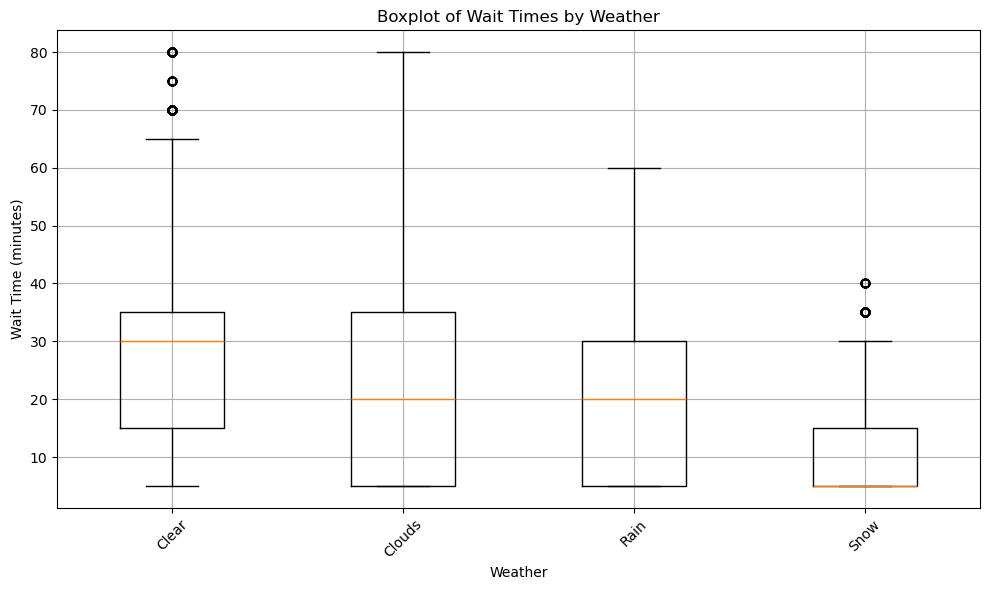

In [974]:
# I had expected weather to be slightly more important in the overall wait times of attractions but the other features seem
# to be a bit more impactful. Nevertheless let's plot how wait times are spread across the different weather values:

weather_main_data = paw.groupby('weather_main')['wait'].apply(list).reset_index()
wait_data = weather_main_data['wait'].tolist()
weather_labels = weather_main_data['weather_main'].tolist()

plt.figure(figsize=(10, 6))
plt.boxplot(wait_data, labels=weather_labels)
plt.xlabel('Weather')
plt.ylabel('Wait Time (minutes)')
plt.title('Boxplot of Wait Times by Weather')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()